# This notebook assimilates experimental and CFD data which can be used as augmentation for the Adversarial VAE.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from google.colab.patches import cv2_imshow



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
directory = '\content\gdrive\MyDrive\Colab Notebooks\Cesar_AE_LSTM\merge_images\example_images'
filenameSimtest = '\simulation_step_1.png'


Mounted at /content/gdrive


Do modifications to assimilate DA and CFD files

In [3]:

directory_exp = '/content/gdrive/MyDrive/Colab Notebooks/Cesar_AE_LSTM/merge_images/example_images/experimental_images_40sec/'
directory_cfd = '/content/gdrive/MyDrive/Colab Notebooks/Cesar_AE_LSTM/merge_images/example_images/cfd_images_100sec/'

#Background
filenameSim = 'small_pub_1_1280-1024.png' 
filenameSimMask = 'small_pub_1_1280-1024.png' 

#Observations
filenameObs = 'output_0001.png'
filenameObsMask = 'output_0001.png'

In [4]:

#read files

min = 0
max = 0.01

def scalerThetis(x, xmin, xmax, min, max):
    scale = (max - min)/(xmax - xmin)
    xScaled = scale*x + min - xmin*scale
    return xScaled


#choose if experiments are observation or state
if 0:
  imgSim = cv2.imread(directory_cfd + filenameSim, 0)[65:,:-80] # 0 is a flag for greyscale, 1 for colour
  imgObs = cv2.imread(directory_exp + filenameObs, 0)[:-65,80:]  #first field moves picture down,second field moves picture to left

  imgSimMask = cv2.imread(directory_cfd + filenameSimMask)[65:,:-80]
  imgObsMask = cv2.imread(directory_exp + filenameObsMask)[:-65,80:]


#switch experiment to background, and VTU file to observation:
if 1:
  imgObs = cv2.imread(directory_cfd + filenameSim, 0)[65:,:-80] # 0 is a flag for greyscale, 1 for colour
  imgSim = cv2.imread(directory_exp + filenameObs, 0)[:-65,80:]  #first field moves picture down,second field moves picture to left

  imgObsMask = cv2.imread(directory_cfd + filenameSimMask)[65:,:-80]
  imgSimMask = cv2.imread(directory_exp + filenameObsMask)[:-65,80:]


Visual inspections of the images

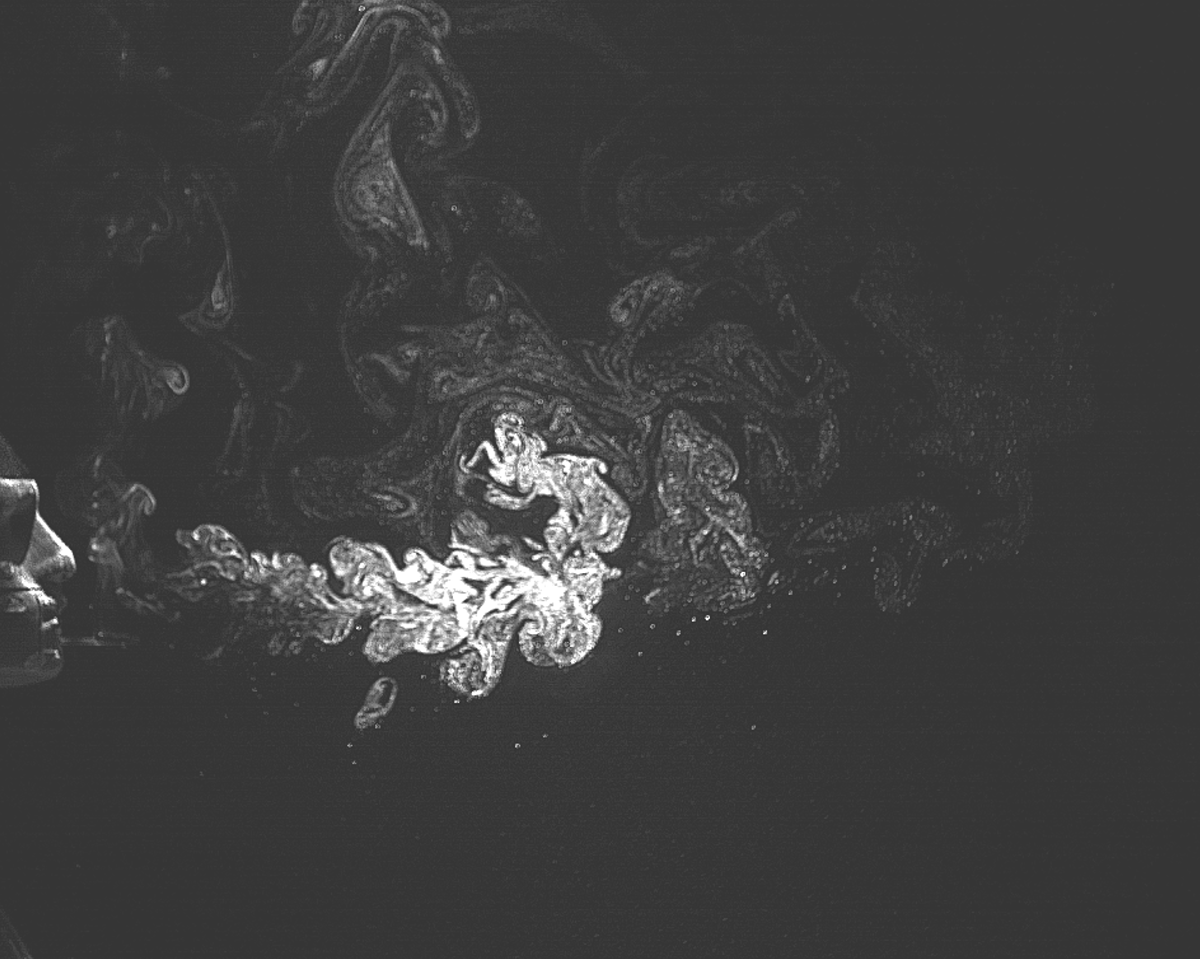

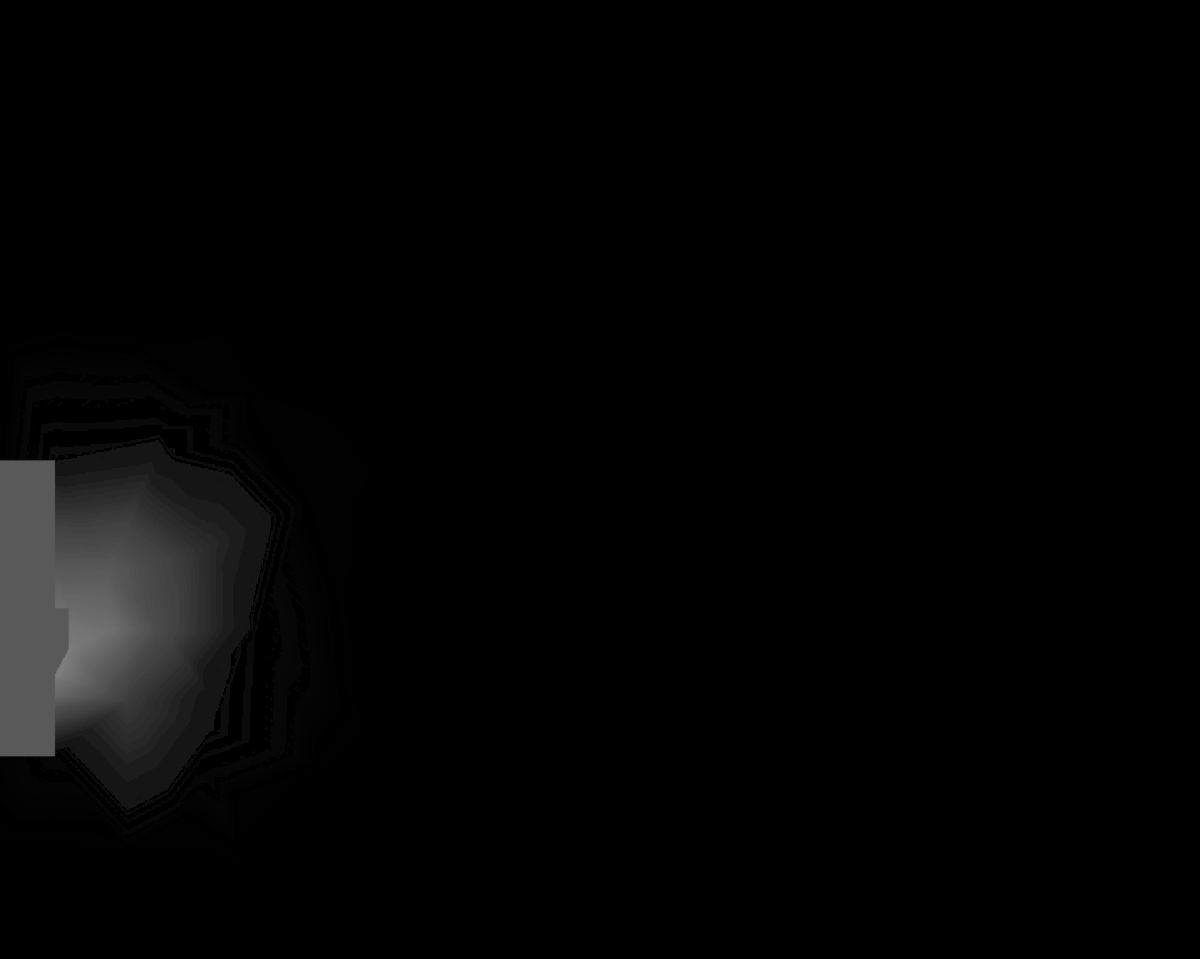

In [5]:
cv2_imshow(imgSim)
cv2_imshow(imgObs)

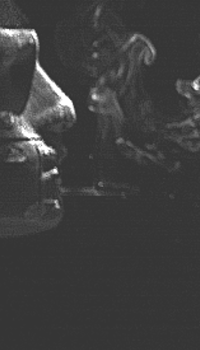

In [6]:
cv2_imshow(imgSim[450:800,:200])

In [7]:
colourMask = [196, 114, 68]

imgSim[np.where(imgSimMask[:,:,1]==114)] = 255
imgObs[np.where(imgObsMask[:,:,1]==114)] = 255
imgSim = cv2.bitwise_not(imgSim)
imgObs = cv2.bitwise_not(imgObs)
imgSim = scalerThetis(imgSim, 0, 255, 0, 0.01)  #(x, xmin, xmax, min, max)
imgObs = scalerThetis(imgObs, 0, 255, 0, 0.01)

#Find the colour of the background and turn it white
grey = imgSim[0,4]
imgSim[np.where(imgSim == grey)] = 0

#Linearised Sim and Obs

linSim = np.reshape(imgSim, (imgSim.shape[0]*imgSim.shape[1]))  #the length here is different, but shouldnt be.
linObs = np.reshape(imgObs, (imgObs.shape[0]*imgObs.shape[1]))

Example Test-Run

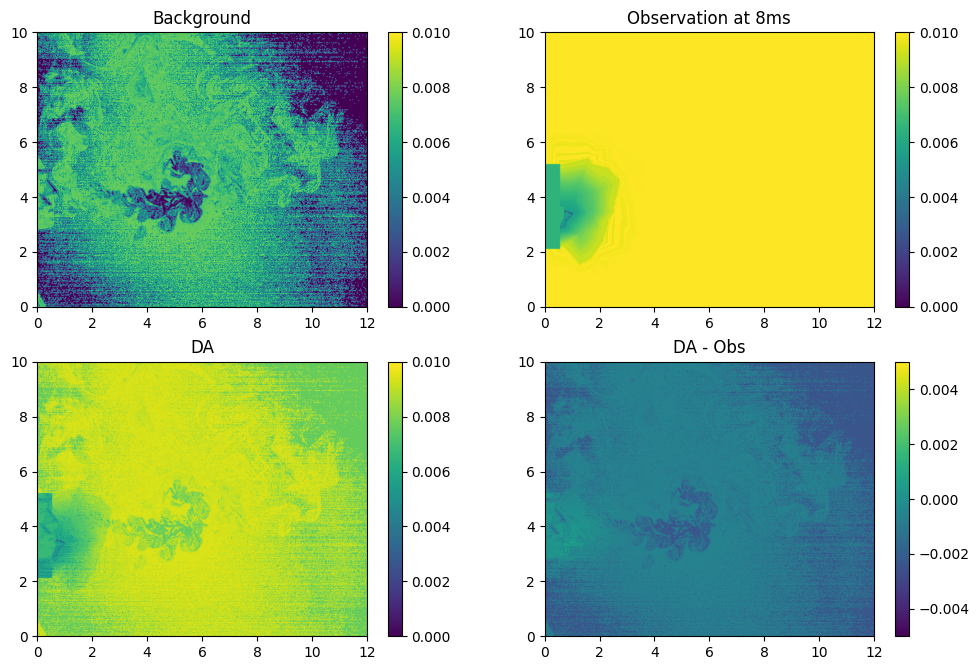

In [9]:


#3DVAR

def J(v):
    vT = np.transpose(v)
    vTv = np.dot(vT, v)
    Vv = np.dot(V, v)
    Jmis = np.subtract(Vv, d)
    invR = np.reciprocal(R)
    JmisT = np.transpose(Jmis)
    RJmis = JmisT.copy()
    J1 = invR * np.dot(Jmis, RJmis)
    Jv = (vTv + J1) / 2
    return Jv


def gradJ(v):
    Vv = np.dot(V, v)
    Jmis = np.subtract(Vv, d)
    invR = np.reciprocal(R)
    g1 = Jmis.copy()
    VT = np.transpose(V)
    g2 = np.dot(VT, g1)
    gg2 = np.multiply(invR, g2)
    ggJ = v + gg2
    return ggJ

#Rvalues = np.linspace(0.1, 1, 10)
#V = np.cov(linSim)
#Vvalues = np.linspace(1, 0.1, 10)
Vvalues = np.linspace(0.8, 0.5, 1) #the higher the more weight to obs
Rvalues = (1 - Vvalues)

for j in Vvalues:
    for i in Rvalues:
        V = j
        R = i
        yobs = linObs
        x0 = np.ones(linSim.shape[0])
        #V = np.loadtxt('/data/TEST3D/TEST1/MatricesPrec105/matrixVprec'+str(m)+'.txt', usecols=range(m))
        Vin = 1/V
        v0 = np.dot(Vin, x0)

        VT = np.transpose(V)
        HxB = linSim.copy()
        d = np.subtract(yobs, HxB)
        #d = np.subtract(yobs, HxB[:383284])

        #t = time.time()
        res = minimize(J, v0, method='L-BFGS-B', jac=gradJ,
                        options={'disp': False})

        vDA = np.array([])
        vDA = res.x
        deltaxDA = np.dot(V,vDA)
        xDA_innov = linSim + deltaxDA

        xDA = np.reshape(xDA_innov, (imgSim.shape[0], imgSim.shape[1]))

        fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
        #fig = plt.figure()
        plt.subplot(221)
        plt.imshow(imgSim, extent=(0,12,0,10))
        plt.clim(min, max)
        plt.colorbar()
        plt.title('Background')
        plt.subplot(222)
        plt.imshow(imgObs, extent=(0,12,0,10))
        plt.clim(min, max)
        plt.colorbar()
        plt.title('Observation at 8ms')
        plt.subplot(223)
        plt.imshow(xDA, extent=(0,12,0,10))
        plt.clim(min, max)
        plt.colorbar()
        plt.title('DA')
        plt.subplot(224)
        plt.imshow(xDA-imgObs, extent=(0,12,0,10))
        plt.clim(-max/2, max/2)
        plt.colorbar()
        plt.title('DA - Obs')
        fig.savefig(directory + '\\output\\' + 'R_' + str(i) + '_V_' + str(j) + '_da_example.png')  # save the figure to file
        plt.plot()


## Here we loop through all 40 seconds of the file

In [ ]:
    def J(v):
        vT = np.transpose(v)
        vTv = np.dot(vT, v)
        Vv = np.dot(V, v)
        Jmis = np.subtract(Vv, d)
        invR = np.reciprocal(R)
        JmisT = np.transpose(Jmis)
        RJmis = JmisT.copy()
        J1 = invR * np.dot(Jmis, RJmis)
        Jv = (vTv + J1) / 2
        return Jv


    def gradJ(v):
        Vv = np.dot(V, v)
        Jmis = np.subtract(Vv, d)
        invR = np.reciprocal(R)
        g1 = Jmis.copy()
        VT = np.transpose(V)
        g2 = np.dot(VT, g1)
        gg2 = np.multiply(invR, g2)
        ggJ = v + gg2
        return ggJ


In [ ]:
  #number of images available
  nr_img = 40
  save_states = []
  for i in range(1,nr_img+1):
    print('picture: ', i)
    ##define filenames
    directory_exp = '/content/gdrive/MyDrive/Colab Notebooks/Cesar_AE_LSTM/merge_images/example_images/experimental_images_40sec/'
    directory_cfd = '/content/gdrive/MyDrive/Colab Notebooks/Cesar_AE_LSTM/merge_images/example_images/cfd_images_100sec/'
    
    #Background
    filenameSim = 'small_pub_'+str(i)+'_1280-1024.png' 
    filenameSimMask = 'small_pub_'+str(i)+'_1280-1024.png' 

    #Observations
    if i < 10:
      filenameObs = 'output_000'+str(i)+'.png'
      filenameObsMask = 'output_000'+str(i)+'.png'
    else:
      filenameObs = 'output_00'+str(i)+'.png'
      filenameObsMask = 'output_00'+str(i)+'.png'

    ##read files
    min = 0
    max = 0.01

    def scalerThetis(x, xmin, xmax, min, max):
        scale = (max - min)/(xmax - xmin)
        xScaled = scale*x + min - xmin*scale
        return xScaled

    imgSim = cv2.imread(directory_cfd + filenameSim, 0)[65:,:-80]
    imgObs = cv2.imread(directory_exp + filenameObs, 0)[:-65,80:]  

    imgSimMask = cv2.imread(directory_cfd + filenameSimMask)[65:,:-80]
    imgObsMask = cv2.imread(directory_exp + filenameObsMask)[:-65,80:]

    ##greyscale
    colourMask = [196, 114, 68]

    imgSim[np.where(imgSimMask[:,:,1]==114)] = 255
    imgObs[np.where(imgObsMask[:,:,1]==114)] = 255
    imgSim = cv2.bitwise_not(imgSim)
    imgObs = cv2.bitwise_not(imgObs)
    imgSim = scalerThetis(imgSim, 0, 255, 0, 0.01)
    imgObs = scalerThetis(imgObs, 0, 255, 0, 0.01)

    #Find the colour of the background and turn it white
    grey = imgSim[0,4]
    imgSim[np.where(imgSim == grey)] = 0

    #Linearised Sim and Obs
    linSim = np.reshape(imgSim, (imgSim.shape[0]*imgSim.shape[1]))  
    linObs = np.reshape(imgObs, (imgObs.shape[0]*imgObs.shape[1]))


    ##3D VAR

    #Rvalues = np.linspace(0.1, 1, 10)
    #V = np.cov(linSim)
    #Vvalues = np.linspace(1, 0.1, 10)
    Vvalues = np.linspace(0.5, 0.5, 1)
    Rvalues = (1 - Vvalues)

    for j in Vvalues:
        for i in Rvalues:
            V = j
            R = i
            yobs = linObs
            x0 = np.ones(linSim.shape[0])
            Vin = 1/V
            v0 = np.dot(Vin, x0)

            VT = np.transpose(V)
            HxB = linSim.copy()
            d = np.subtract(yobs, HxB)
            #d = np.subtract(yobs, HxB[:383284])

            #t = time.time()
            res = minimize(J, v0, method='L-BFGS-B', jac=gradJ,
                            options={'disp': False})

            vDA = np.array([])
            vDA = res.x
            deltaxDA = np.dot(V,vDA)
            xDA_innov = linSim + deltaxDA

            xDA = np.reshape(xDA_innov, (imgSim.shape[0], imgSim.shape[1]))
            

            #choose if images or not
            if 0:
              fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
              #fig = plt.figure()
              plt.subplot(221)
              plt.imshow(imgSim, extent=(0,12,0,10))
              plt.clim(min, max)
              plt.colorbar()
              plt.title('Background')
              plt.subplot(222)
              plt.imshow(imgObs, extent=(0,12,0,10))
              plt.clim(min, max)
              plt.colorbar()
              plt.title('Observation at 8ms')
              plt.subplot(223)
              plt.imshow(xDA, extent=(0,12,0,10))
              plt.clim(min, max)
              plt.colorbar()
              plt.title('DA')
              plt.subplot(224)
              plt.imshow(xDA-imgObs, extent=(0,12,0,10))
              plt.clim(-max/2, max/2)
              plt.colorbar()
              plt.title('DA - Obs')
              #fig.savefig(directory + '\\output\\' + 'R_' + str(i) + '_V_' + str(j) + '_da_example.png')  # save the figure to file
              plt.plot()

    save_states.append(xDA)
    print('before da : ', np.mean(np.abs(imgSim-imgObs)))
    print('after da : ', np.mean(np.abs(xDA-imgObs)))

picture:  1
before da :  0.006517139415376855
after da :  0.004344759626509181
picture:  2
before da :  0.0057994810430254794
after da :  0.003866320683929523
picture:  3
before da :  0.005645311156092609
after da :  0.003763540767205241
picture:  4
before da :  0.0052520544957642456
after da :  0.003501369660933126
picture:  5
before da :  0.004903762497699812
after da :  0.0032691749843952907
picture:  6
before da :  0.0018429167433396715
after da :  0.0012286111630162384
picture:  7
before da :  0.0019525273467051055
after da :  0.0013016848981176295
picture:  8
before da :  0.0016155653015464085
after da :  0.001077043530809781
picture:  9
before da :  0.001998145024433131
after da :  0.0013320966841205493
picture:  10
before da :  0.0014212078554049358
after da :  0.0009474719089897253
picture:  11
before da :  0.0012444967183953873
after da :  0.0008296644801527133
picture:  12
before da :  0.001179570835633524
after da :  0.0007863805594570298
picture:  13
before da :  0.0014873

This pickles the state object and can be used as extra state for experiments with the Adv. VAE

In [ ]:
#use this to pickle object and save
if 1:
  import sys
  sys.getsizeof(save_states)#returns size in bytes
  
  import pickle
  f = open("/content/gdrive/MyDrive/Colab Notebooks/Cesar_AE_LSTM/merge_images/example_images/states_pickled", "wb")
  pickle.dump(save_states, f)
  f.close()